In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# =====================
# CONFIG
# =====================
IMG_SIZE = 224
BATCH_SIZE = 16

DATASET_DIR = r"C:\Users\adity\Downloads\dataset_split_final"

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "val")
test_dir  = os.path.join(DATASET_DIR, "test")

# =====================
# DATA GENERATOR
# =====================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# =====================
# GENERATORS
# =====================
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# =====================
# INFO
# =====================
NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())

print("Number of Classes :", NUM_CLASSES)
print("Class Names       :", CLASS_NAMES)


Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Number of Classes : 10
Class Names       : ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ===============================
# Konfigurasi Model
# ===============================
IMG_HEIGHT = 224
IMG_WIDTH = 224
LEARNING_RATE = 1e-4
FREEZE_LAYERS = 20  # jumlah layer terakhir yang dilatih ulang

# ===============================
# Jumlah Kelas (dari generator)
# ===============================
num_classes = len(train_gen.class_indices)
print("Number of Classes:", num_classes)

# ===============================
# Base Model: MobileNetV3Small
# ===============================
base_model = MobileNetV3Small(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze layer (transfer learning tahap awal)
for layer in base_model.layers[:-FREEZE_LAYERS]:
    layer.trainable = False

# ===============================
# Classification Head
# ===============================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

# ===============================
# Final Model
# ===============================
model = Model(inputs=base_model.input, outputs=output)

# ===============================
# Compile Model
# ===============================
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ===============================
# Model Summary
# ===============================
model.summary()


Number of Classes: 10


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_18 (Activation)    │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 113, 113, 16)      │               0 │ activation_18[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 56, 56, 16)        │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 56, 56, 16)        │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 56, 56, 16)        │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu_14[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 1, 1, 16)          │               

 Total params: 944,890 (3.60 MB)

 Trainable params: 356,506 (1.36 MB)

 Non-trainable params: 588,384 (2.24 MB)

In [6]:
import time
import tensorflow as tf

# ===============================
# Custom Callback: Training Time
# ===============================
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_generator):
        super().__init__()
        self.total_train_samples = train_gen.samples

    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        print("\nStarting training...")

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1} begins...")

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        print(f"Epoch {epoch + 1} ended.")
        print(f"  Epoch duration      : {epoch_duration:.2f} seconds")

        if self.total_train_samples > 0:
            time_per_image = epoch_duration / self.total_train_samples
            print(f"  Approx. time/image  : {time_per_image:.6f} seconds")

    def on_train_end(self, logs=None):
        total_duration = time.time() - self.train_start_time
        print(f"\nTraining finished.")
        print(f"Total training time   : {total_duration:.2f} seconds")


# ===============================
# Callbacks
# ===============================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="mobilenetv3_tomato_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

timing_callback = TimingCallback(train_gen)

# ===============================
# Model Training
# ===============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint, timing_callback]
)



Starting training...

Epoch 1 begins...
Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3759 - loss: 1.8136
Epoch 1: val_accuracy improved from -inf to 0.57600, saving model to mobilenetv3_tomato_best.h5


Epoch 1 ended.
  Epoch duration      : 58.96 seconds
  Approx. time/image  : 0.006551 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.3763 - loss: 1.8126 - val_accuracy: 0.5760 - val_loss: 1.1694

Epoch 2 begins...
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8300 - loss: 0.5197
Epoch 2: val_accuracy improved from 0.57600 to 0.81400, saving model to mobilenetv3_tomato_best.h5


Epoch 2 ended.
  Epoch duration      : 50.40 seconds
  Approx. time/image  : 0.005600 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.8300 - loss: 0.5196 - val_accuracy: 0.8140 - val_loss: 0.5789

Epoch 3 begins...
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8931 - loss: 0.3179
Epoch 3: val_accuracy improved from 0.81400 to 0.88300, saving model to mobilenetv3_tomato_best.h5


Epoch 3 ended.
  Epoch duration      : 49.29 seconds
  Approx. time/image  : 0.005477 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - accuracy: 0.8931 - loss: 0.3179 - val_accuracy: 0.8830 - val_loss: 0.3534

Epoch 4 begins...
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9284 - loss: 0.2270
Epoch 4: val_accuracy improved from 0.88300 to 0.91200, saving model to mobilenetv3_tomato_best.h5


Epoch 4 ended.
  Epoch duration      : 51.38 seconds
  Approx. time/image  : 0.005709 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.9284 - loss: 0.2270 - val_accuracy: 0.9120 - val_loss: 0.2424

Epoch 5 begins...
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9381 - loss: 0.1895
Epoch 5: val_accuracy improved from 0.91200 to 0.92200, saving model to mobilenetv3_tomato_best.h5


Epoch 5 ended.
  Epoch duration      : 54.94 seconds
  Approx. time/image  : 0.006104 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 55s 98ms/step - accuracy: 0.9381 - loss: 0.1894 - val_accuracy: 0.9220 - val_loss: 0.1982

Epoch 6 begins...
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9540 - loss: 0.1448
Epoch 6: val_accuracy improved from 0.92200 to 0.93700, saving model to mobilenetv3_tomato_best.h5


Epoch 6 ended.
  Epoch duration      : 52.80 seconds
  Approx. time/image  : 0.005867 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9540 - loss: 0.1448 - val_accuracy: 0.9370 - val_loss: 0.1852

Epoch 7 begins...
Epoch 7/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9620 - loss: 0.1218
Epoch 7: val_accuracy improved from 0.93700 to 0.94100, saving model to mobilenetv3_tomato_best.h5


Epoch 7 ended.
  Epoch duration      : 52.65 seconds
  Approx. time/image  : 0.005850 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.9620 - loss: 0.1218 - val_accuracy: 0.9410 - val_loss: 0.1723

Epoch 8 begins...
Epoch 8/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9637 - loss: 0.1078
Epoch 8: val_accuracy did not improve from 0.94100
Epoch 8 ended.
  Epoch duration      : 52.58 seconds
  Approx. time/image  : 0.005842 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.9638 - loss: 0.1078 - val_accuracy: 0.9360 - val_loss: 0.1655

Epoch 9 begins...
Epoch 9/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9734 - loss: 0.0806
Epoch 9: val_accuracy did not improve from 0.94100
Epoch 9 ended.
  Epoch duration      : 53.99 seconds
  Approx. time/image  : 0.005998 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.9734 - loss: 0.0806 - val_accuracy: 0.9410 - val_loss: 0.1666

Epoch 10 begins...
Epoch 10/30
563/563 ━━━━━━━

Epoch 13 ended.
  Epoch duration      : 54.74 seconds
  Approx. time/image  : 0.006082 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - accuracy: 0.9845 - loss: 0.0412 - val_accuracy: 0.9490 - val_loss: 0.1671

Epoch 14 begins...
Epoch 14/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9875 - loss: 0.0450
Epoch 14: val_accuracy did not improve from 0.94900
Epoch 14 ended.
  Epoch duration      : 55.84 seconds
  Approx. time/image  : 0.006204 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 56s 99ms/step - accuracy: 0.9875 - loss: 0.0450 - val_accuracy: 0.9490 - val_loss: 0.1650

Epoch 15 begins...
Epoch 15/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9876 - loss: 0.0369
Epoch 15: val_accuracy did not improve from 0.94900
Epoch 15 ended.
  Epoch duration      : 55.52 seconds
  Approx. time/image  : 0.006169 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 56s 99ms/step - accuracy: 0.9876 - loss: 0.0369 - val_accuracy: 0.9470 - val_loss: 0.1376

Epoch 16 begins...
Epoch 16/30
563/56

Epoch 18 ended.
  Epoch duration      : 53.90 seconds
  Approx. time/image  : 0.005988 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.9907 - loss: 0.0306 - val_accuracy: 0.9530 - val_loss: 0.1608

Epoch 19 begins...
Epoch 19/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9946 - loss: 0.0189
Epoch 19: val_accuracy improved from 0.95300 to 0.95400, saving model to mobilenetv3_tomato_best.h5


Epoch 19 ended.
  Epoch duration      : 53.49 seconds
  Approx. time/image  : 0.005943 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.9946 - loss: 0.0189 - val_accuracy: 0.9540 - val_loss: 0.1621

Epoch 20 begins...
Epoch 20/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9935 - loss: 0.0193
Epoch 20: val_accuracy did not improve from 0.95400
Epoch 20 ended.
  Epoch duration      : 54.41 seconds
  Approx. time/image  : 0.006046 seconds
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 97ms/step - accuracy: 0.9935 - loss: 0.0193 - val_accuracy: 0.9470 - val_loss: 0.1721
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.

Training finished.
Total training time   : 1077.64 seconds


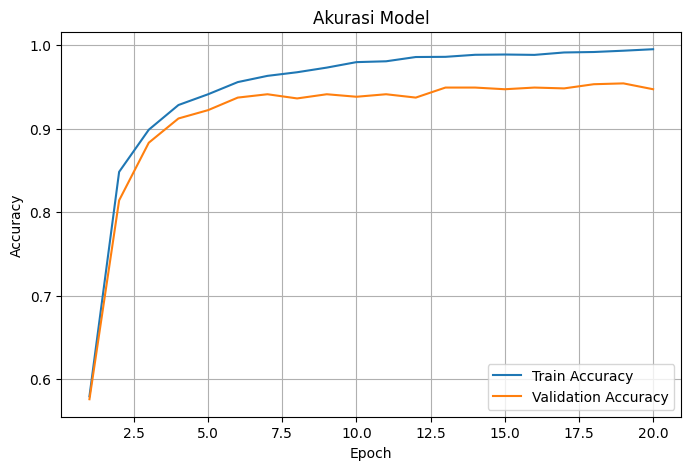

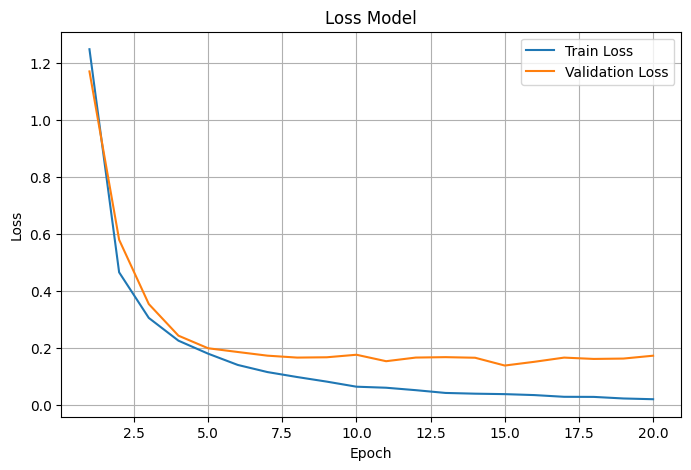

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9509 - loss: 0.1160

Akurasi Validasi Akhir : 94.70%
Loss Validasi Akhir    : 0.1376


In [8]:
import matplotlib.pyplot as plt

# ===============================
# Ambil history training
# ===============================
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

epochs_range = range(1, len(acc) + 1)

# ===============================
# Plot Akurasi
# ===============================
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Akurasi Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# Plot Loss
# ===============================
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Loss Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# Evaluasi Model pada Validation Set
# ===============================
val_loss_final, val_acc_final = model.evaluate(val_gen, verbose=1)

print(f"\nAkurasi Validasi Akhir : {val_acc_final * 100:.2f}%")
print(f"Loss Validasi Akhir    : {val_loss_final:.4f}")


In [11]:
model.save("baseline_mobilenetv3_final.keras")
